Copyright (c) 2015, 2016
[Sebastian Raschka](http://sebastianraschka.com/)
[Li-Yi Wei](http://liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 3 - A Tour of Machine Learning Classifiers

* Logistic regression
 * Binary and multiple classes
* Support vector machine
 * Kernel trick
* Decision tree
 * Random forest for ensemble learning
* K nearest neighbors

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,sklearn

last updated: 2016-10-01 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
sklearn 0.17.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
- [First steps with scikit-learn](#First-steps-with-scikit-learn)
    - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
- [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
    - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
    - [Learning the weights of the logistic cost function](#Learning-the-weights-of-the-logistic-cost-function)
    - [Handling multiple classes](#Handling-multiple-classes)
    - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
    - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
- [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
    - [Maximum margin intuition](#Maximum-margin-intuition)
    - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
    - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
- [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
    - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)
- [Decision tree learning](#Decision-tree-learning)
    - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
    - [Building a decision tree](#Building-a-decision-tree)
    - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
- [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)
- [Summary](#Summary)

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Choosing a classification algorithm

There is no free lunch; different algorithms are suitable for different data and applications.

<img src="./images/01_09.png" width=100%>

# First steps with scikit-learn

In the linear perceptron part, we wrote the models from ground up.
* too much coding

Existing machine learning libraries
* scikit-learn
* torch7, caffe, tensor-flow, theano, etc.

Scikit-learn
* will use for this course
* not as powerful as other deep learning libraries
* easier to use/install
* many library routines and data-sets to use, as exemplified below for main steps for a machine learning pipeline.

## <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris dataset</a>

Let's use this dataset for comparing machine learning methods

<table style="width:100% border=0">
<tr>
<td>
<img src ="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/220px-Kosaciec_szczecinkowaty_Iris_setosa.jpg">
</td>

<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/220px-Iris_versicolor_3.jpg">
</td>

<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg">
</td>
</tr>

<tr style="text-align=center">
<td>
Setosa
</td>
<td>
Versicolor
</td>
<td>
Virginica
</td>
</tr>
</table>

Loading the Iris dataset from scikit-learn. 

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

print('Data set size: ' + str(iris.data.shape))

X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Data set size: (150, 4)
Class labels: [0 1 2]


In [5]:
import pandas as pd
df = pd.DataFrame(iris.data)
df.tail()

0    1    2    3
145  6.7  3.0  5.2  2.3
146  6.3  2.5  5.0  1.9
147  6.5  3.0  5.2  2.0
148  6.2  3.4  5.4  2.3
149  5.9  3.0  5.1  1.8

<img src = "./images/01_08.png">

Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. 

The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

## Data sets: training versus test

Use different data sets for training and testing a model (generalization)

In [6]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

# splitting data into 70% training and 30% test data: 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [7]:
num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 105, test: 45


## Data scaling

It is better to scale the data so that different features/channels have similar mean/std.

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Training a perceptron via scikit-learn

We learned and coded perceptron in chapter 2.
Here we use the scikit-learn library version.

The perceptron only handles 2 classes for now.
We will discuss how to handle $N > 2$ classes.

<img src="./images/02_04.png" width=80%>

In [9]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
_ = ppn.fit(X_train_std, y_train)

In [10]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d out of %d' % ((y_test != y_pred).sum(), y_test.shape[0]))

Misclassified samples: 4 out of 45


In [11]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.91


In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, 
                          resolution=0.02, xlabel='', ylabel='', title=''):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

Training a perceptron model using the standardized training data:

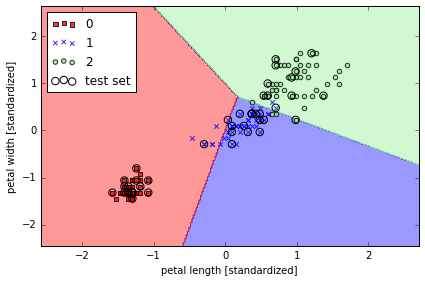

In [13]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

test_idx = range(X_train_std.shape[0], X_combined_std.shape[0])

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', 
                      ylabel='petal width [standardized]')

# Modeling class probabilities via logistic regression

* $\mathbf{x}$: input
* $\mathbf{w}$: weights
* $z = \mathbf{w}^T \mathbf{x}$
* $\phi(z)$: transfer function
* $y$: predicted class

## Perceptron
$
y = \phi(z) = 
\begin{cases}
1 \; z \geq 0 \\
-1 \; z < 0
\end{cases}
$

## Adaline
$
\begin{align}
\phi(z) &= z \\
y &=
\begin{cases}
1 \; \phi(z) \geq 0 \\
-1 \; \phi(z) < 0
\end{cases}
\end{align}
$

## Logistic regression
$
\begin{align}
\phi(z) &= \frac{1}{1 + e^{-z}} \\
y &=
\begin{cases}
1 \; \phi(z) \geq 0.5 \\
0 \; \phi(z) < 0.5
\end{cases}
\end{align}
$

Note: this is actually classification (discrete output) not regression (continuous output); the naming is historical.

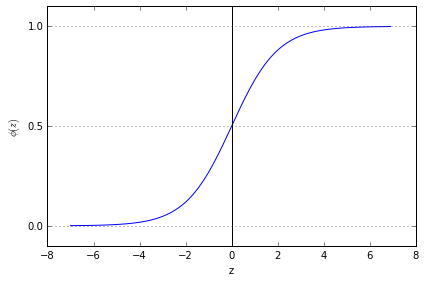

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('./figures/sigmoid.png', dpi=300)
plt.show()

### Logistic regression intuition and conditional probabilities

$\phi(z) = \frac{1}{1 + e^{-z}}$: sigmoid function

$\phi(z) \in [0, 1]$, so can be interpreted as probability: $P(y = 1 \; | \; \mathbf{x} ; \mathbf{w}) = \phi(\mathbf{w}^T \mathbf{x})$

We can then choose class by interpreting the probability:
$
\begin{align}
y &=
\begin{cases}
1 \; \phi(z) \geq 0.5 \\
0 \; \phi(z) < 0.5
\end{cases}
\end{align}
$

The probability information can be very useful for many applications
* knowing the confidence of a prediction in addition to the prediction itself
* e.g. weather forecast: tomorrow might rain versus tomorrow might rain with 70% chance

Perceptron:
<img src="./images/02_04.png" width=100%>

Adaline:
<img src="./images/02_09.png" width=100%>

Logistic regression:
<img src="./images/03_03.png" width=100%> 

### Learning the weights of the logistic cost function

$J(\mathbf{w})$: cost function to minimize with parameters $\mathbf{w}$

$z = \mathbf{w}^T \mathbf{x}$

For Adaline, we minimize sum-of-squared-error:
$$
J(\mathbf{w}) = \frac{1}{2} \sum_i \left( y^{(i)} - t^{(i)}\right)^2
= \frac{1}{2} \sum_i \left( \phi\left(z^{(i)}\right) - t^{(i)}\right)^2
$$

#### Maximum likelihood estimation (MLE)
For logistic regression, we take advantage of the probability interpretation to maximize the likelihood:
$$
L(\mathbf{w}) = P(t \; | \; \mathbf{x}; \mathbf{w}) = \prod_i P\left( t^{(i)} \; | \; \mathbf{x}^{(i)} ; \mathbf{w} \right) = \prod_i \phi\left(z^{(i)}\right)^{t^{(i)}} \left(1 - \phi\left(z^{(i)}\right)\right)^{1-t^{(i)}}
$$

Why?
$$
\begin{align}
\phi\left(z^{(i)}\right)^{t^{(i)}} \left(1 - \phi\left(z^{(i)}\right)\right)^{1-t^{(i)}} =
\begin{cases}
\phi\left(z^{(i)} \right) & \; if \; t^{(i)} = 1 \\
1 - \phi\left(z^{(i)}\right) & \; if \; t^{(i)} = 0
\end{cases}
\end{align}
$$


This is equivalent to minimize the negative log likelihood:
$$
J(\mathbf{w}) 
= -\log L(\mathbf{w}) 
= \sum_i -t^{(i)}\log\left(\phi\left(z^{(i)}\right)\right) - \left(1 - t^{(i)}\right) \log\left(1 - \phi\left(z^{(i)}\right) \right)
$$

Converting prod to sum via log() is a common math trick for easier computation.

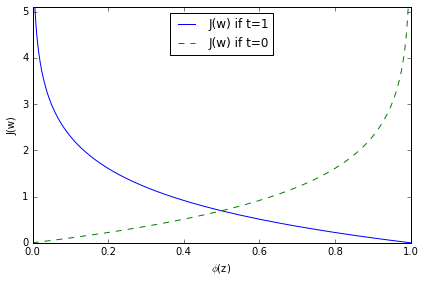

In [15]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if t=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if t=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/log_cost.png', dpi=300)
plt.show()

### Relationship to cross entropy

### Optimizing for logistic regression

From 
$$
\frac{\partial \log\left(x\right)}{\partial x} = \frac{1}{x}
$$
and chain rule:
$$
\frac{\partial f\left(y\left(x\right)\right)}{\partial x} = \frac{\partial f(y)}{\partial y} \frac{\partial y}{\partial x}
$$

We know
$$
J(\mathbf{w}) 
= \sum_i -t^{(i)}\log\left(\phi\left(z^{(i)}\right)\right) - \left(1 - t^{(i)}\right) \log\left(1 - \phi\left(z^{(i)}\right) \right)
$$

$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} =
\sum_i \left(\frac{-t^{(i)}}{\phi\left(z^{(i)}\right)} + \frac{1- t^{(i)}}{1 - \phi\left(z^{(i)}\right)} \right) \frac{\partial \phi \left(z^{(i)}\right)}{\partial \mathbf{w}}
$$

For sigmoid 
$
\frac{\partial \phi(z)}{\partial z} = \phi(z)\left(1-\phi(z)\right)
$

Thus
$$
\begin{align}
\delta J =
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} &=
\sum_i \left(\frac{-t^{(i)}}{\phi\left(z^{(i)}\right)} + \frac{1- t^{(i)}}{1 - \phi\left(z^{(i)}\right)} \right) 
\phi\left(z^{(i)}\right)\left(1 - \phi\left(z^{(i)}\right) \right)
\frac{\partial z^{(i)}}{\partial \mathbf{w}} \\
&=
\sum_i \left( -t^{(i)}\left(1 - \phi\left(z^{(i)}\right)\right) + \left(1-t^{(i)}\right)\phi\left(z^{(i)}\right) \right) \mathbf{x}^{(i)} \\
&=
\sum_i \left( -t^{(i)} + \phi\left( z^{(i)} \right) \right) \mathbf{x}^{(i)}
\end{align}
$$

For gradient descent
$$
\begin{align}
\delta \mathbf{w} &= -\eta \delta J = \eta \sum_i \left( t^{(i)} - \phi\left( z^{(i)} \right) \right) \mathbf{x}^{(i)} \\
\mathbf{w} & \leftarrow \mathbf{w} + \delta \mathbf{w}
\end{align}
$$
as related to what we did for optimizing in chapter 2.

### Handling multiple classes

So far we have discussed only binary classifiers for 2 classes.

How about $K > 2$ classes, e.g. $K=3$ for the Iris dataset?

#### Multiple binary classifiers

##### One versus one

Build $\frac{K(K-1)}{2}$ classifiers,
each separating a different pair of classes $C_i$ and $C_j$

<a href="https://www.microsoft.com/en-us/research/people/cmbishop/" title="Figure 4.2(b), PRML, Bishop">
<img src="./images/one_vs_one.svg">
</a>

The green region is ambiguous: $C_1$, $C_2$, $C_3$

##### One versus rest (aka one versus all)

Build $K$ binary classifiers, 
each separating class $C_k$ from the rest

<a href="https://www.microsoft.com/en-us/research/people/cmbishop/" title="Figure 4.2(a), PRML, Bishop">
<img src="./images/one_vs_rest.svg">
</a>

The green region is ambiguous: $C_1$, $C_2$

#### Ambiguity

Both one-versus-one and one-versus-all have ambiguous regions and may incur more complexity/computation.

Ambiguity can be resolved via tie breakers, e.g.:
* activation values 
* majority voting
* more details: http://scikit-learn.org/stable/modules/multiclass.html

#### One multi-class classifier

Multiple activation functions $\phi_k, k=1, 2, ... K$ each with different parameters
$$
\phi_k\left(\mathbf{x}\right) = \phi\left(\mathbf{x}, \mathbf{w_k}\right) = \phi\left(\mathbf{w}_k^T \mathbf{x} \right)
$$

We can then choose the class based on maximum activation:
$$
y = argmax_k \; \phi_k\left( \mathbf{x} \right)
$$

#### Can also apply the above for multiple binary classifiers

Caveat
* need to assume the individual classifiers have compatible activations
* https://en.wikipedia.org/wiki/Multiclass_classification

Binary logistic regression:

$$
J(\mathbf{w}) 
= \sum_{i \in samples} -t^{(i)}\log\left(\phi\left(z^{(i)}\right)\right) - \left(1 - t^{(i)}\right) \log\left(1 - \phi\left(z^{(i)}\right) \right)
$$

Multi-class logistic regression:
$$
J(\mathbf{w}) 
= \sum_{i \in samples} \sum_{j \in classes} -t^{(i, j)}\log\left(\phi\left(z^{(i, j)}\right)\right) - \left(1 - t^{(i, j)}\right) \log\left(1 - \phi\left(z^{(i, j)}\right) \right)
$$


For $\phi \geq 0$, we can normalize for probabilistic interpretation:
$$
P\left(k \; | \; \mathbf{x} ; \{\mathbf{w}_k\} \right) =
\frac{\phi_k\left(\mathbf{x}\right)}{\sum_{m=1}^K \phi_m\left(\mathbf{x}\right) }
$$

Or use softmax (normalized exponential) for any activation $\phi$:
$$
P\left(k \; | \; \mathbf{x} ; \{\mathbf{w}_k\} \right) =
\frac{e^{\phi_k\left(\mathbf{x}\right)}}{\sum_{m=1}^K e^{\phi_m\left(\mathbf{x}\right)} }
$$

For example, if $\phi(z) = z$:
$$
P\left(k \; | \; \mathbf{x} ; \{\mathbf{w}_k\} \right) =
\frac{e^{\mathbf{w}_k^T\mathbf{x}}}{\sum_{m=1}^K e^{\mathbf{w}_m^T \mathbf{x}} }
$$


For training, the model can be optimized via gradient descent.

The likelihood function (to maximize):
$$
L(\mathbf{w}) 
= P(t \; | \; \mathbf{x}; \mathbf{w}) 
= \prod_i P\left( t^{(i)} \; | \; \mathbf{x}^{(i)} ; \mathbf{w} \right)
$$

The loss function (to minimize):
$$
J(\mathbf{w}) 
= -\log{L(\mathbf{w})}
= -\sum_i \log{P\left( t^{(i)} \; | \; \mathbf{x}^{(i)} ; \mathbf{w} \right)}
$$

### Training a logistic regression model with scikit-learn

The code is quite simple.

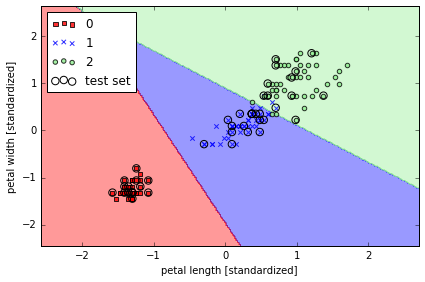

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=test_idx,
                      xlabel = 'petal length [standardized]', 
                      ylabel='petal width [standardized]')

In [17]:
if False: #Version(sklearn_version) < '0.18':
    print(lr.predict_proba(X_test_std[0, :]))
else:
    print(lr.predict_proba(X_test_std[0, :].reshape(1, -1)))


[[  2.05743774e-11   6.31620264e-02   9.36837974e-01]]


### Tackling overfitting via regularization

Recall our general representation of our modeling objective:
$$\Phi(\mathbf{X}, \mathbf{T}, \Theta) = L\left(\mathbf{X}, \mathbf{T}, \mathbf{Y}=f(\mathbf{X}, \Theta)\right) + P(\Theta)$$
* $L$ - loss/objective for data fitting
* $P$ - regularization to favor simple model

Need to balance between accuracy/bias (L) and complexity/variance (P)

* If the model is too simple, it might be inaccurate (high bias)
* If the model is too complex, it might over-fit and over-sensitive to training data (high variance)

A well-trained model should 
* fit the training data well (low bias)
* remain stable with different training data for good generalization (to unseen future data; low variance)

The following illustrates bias and variance for a potentially non-linear model

<img src="./images/03_06.png" width=100%> 

$L_2$ norm is a common form for regularization, e.g.
$
P = \lambda ||\mathbf{w}||^2
$
for the linear weights $\mathbf{w}$

$\lambda$ is a parameter to weigh between bias and variance

$C = \frac{1}{\lambda}$ for scikit-learn

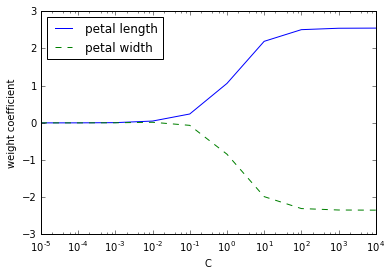

In [18]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    # coef_ has shape (n_classes, n_features)
    # we visualize only class 1
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('./figures/regression_path.png', dpi=300)
plt.show()

# Reading
* PML Chapter 3

# Maximum margin classification with support vector machines

Another popular type of machine learning algorithm
* basic version for linear classification
* kernel version for non-linear classification

Linear classification

* decision boundary 
$
\mathbf{w}^T \mathbf{x}
\begin{cases}
\geq 0 \; class +1 \\
< 0 \; class -1
\end{cases}
$
* similar to perceptron
* based on different criteria

Perceptron
* minimize misclassification error
* more sensitive to outliers
* incremental learning (via SGD)

SVM
* maximize margins to nearest samples (called support vectors)
* more robust against outliers
* batch learning

<img src="./images/03_07.png" width=100%>

## Maximum margin intuition

Maximize the margins of support vectors to the decision plane $\rightarrow$ more robust classification for future samples (that may lie close to the decision plane)

Let us start with the simple case of two classes with labels +1 and -1.
(We choose this particular combination of labeling for numerical simplicity, as follows.)
Let the training dataset be $\{\mathbf{x}^{(i)}, y^{(i)}\}$, $i=1$ to $N$.

The goal is to find hyper-plane parameters $\mathbf{w}$ and $w_0$ so that
$$y^{(i)} \left( \mathbf{w}^T\mathbf{x}^{(i)} + w_0\right) \geq 1, \; \forall i$$.

Note that $y^{(i)} = \pm1$ above.

<font color='blue'>
<ul>
<li> We use t or y for target labels depending on the context

<li> We separate out $w_0$ from the rest of 
$
\mathbf{w} = 
\begin{bmatrix} 
w_1 \\
w_2 \\
\vdots \\
w_n 
\end{bmatrix} 
$ for math derivation below
</ul>
</font>

### Geometry perspective
For the purpose of optimization, we can cast the problem as maximize $\rho$ for:
$$\frac{y^{(i)} \left( \mathbf{w}^T\mathbf{x}^{(i)} + w_0\right)}{||\mathbf{w}||} \geq \rho, \; \forall i$$
; note that the left-hand side can be interpreted as the distance from $\mathbf{x}^{(i)}$ to the hyper-plane.

### Scaling
Note that the above equation remains invariant if we multiply $||\mathbf{w}||$ and $w_0$ by any non-zero scalar.

To eliminate this ambiguity, we can fix $\rho ||\mathbf{w}|| = 1$ and minimize $||\mathbf{w}||$, i.e.:
min $\frac{1}{2} ||\mathbf{w}||^2$ subject to $y^{(i)}\left( \mathbf{w}^T \mathbf{x}^{(i)} + w_0\right) \geq 1, \; \forall i$

### Optimization
We can use <a href="https://en.wikipedia.org/wiki/Lagrange_multiplier">Lagrangian multipliers</a> $\alpha^{(i)}$ for this constrained optimization problem:
$$
\begin{align}
L(\mathbf{w}, w_0, \alpha) 
&=
\frac{1}{2} ||\mathbf{w}||^2 - \sum_i \alpha^{(i)} \left( y^{(i)} \left( \mathbf{w}^T \mathbf{x}^{(i)} + w_0\right) -1 \right)
\\
&=
\frac{1}{2} ||\mathbf{w}||^2 - \sum_i \alpha^{(i)} y^{(i)} \left( \mathbf{w}^T \mathbf{x}^{(i)} + w_0\right) + \sum_i \alpha^{(i)}
\end{align}
$$
<!--
(The last term above is for $\alpha^{(i)} \geq 0$.)
-->


With some calculus/algebraic manipulations:
$$\frac{\partial L}{\partial \mathbf{w}} = 0 \Rightarrow \mathbf{w} = \sum_i \alpha^{(i)} y^{(i)} \mathbf{x}^{(i)}$$
$$\frac{\partial L}{\partial w_0} = 0 \Rightarrow \sum_i \alpha^{(i)} y^{(i)} = 0$$


Plug the above two into $L$ above, we have:
$$
\begin{align}
L(\mathbf{w}, w_0, \alpha) &= \frac{1}{2} \mathbf{w}^T \mathbf{w} - \mathbf{w}^T \sum_i \alpha^{(i)}y^{(i)}\mathbf{x}^{(i)} - w_0 \sum_i \alpha^{(i)} y^{(i)} + \sum_i \alpha^{(i)} \\
&= -\frac{1}{2} \mathbf{w}^T \mathbf{w} + \sum_i \alpha^{(i)} \\
&= -\frac{1}{2} \sum_i \sum_j \alpha^{(i)} \alpha^{(j)} y^{(i)} y^{(j)} \left( \mathbf{x}^{(i)}\right)^T \mathbf{x}^{(j)} + \sum_i \alpha^{(i)}
\end{align}
$$
, which can be maximized, via quadratic optimization with $\alpha^{(i)}$ only, subject to the constraints: $\sum_i \alpha^{(i)} y^{(i)} = 0$ and $\alpha^{(i)} \geq 0, \; \forall i$

Note that $y^{(i)} = \pm 1$.

Once we solve $\{ \alpha^{(i)} \}$ we will see that most of them are $0$ with a few $> 0$. 

The $>0$ ones correspond to lie on the decision boundaries and thus called support vectors:
$$y^{(i)} \left( \mathbf{w}^T \mathbf{x}^{(i)} + w_0\right) = 1$$
from which we can calculate $w_0$.


## Dealing with the nonlinearly separable case using slack variables

Soft margin classification

Some datasets are not linearly separable

Avoid thin margins for linearly separable cases
* bias variance tradeoff

For datasets that are not linearly separable, we can introduce slack variables $\{\xi^{(i)}\}$ as follows:
$$y^{(i)} \left( \mathbf{w}^T \mathbf{x}^{(i)} + w_0\right) \geq 1 - \xi^{(i)}, \; \forall i$$

* If $\xi^{(i)} = 0$, it is just like the original case without slack variables.
* If $0 < \xi^{(i)} <1$, $\mathbf{x}^{(i)}$ is correctly classified but lies within the margin.
* If $\xi^{(i)} \geq 1$, $\mathbf{x}^{(i)}$ is mis-classified.


For optimization, the goal is to minimize
$$\frac{1}{2} ||\mathbf{w}||^2 + C \sum_i \xi^{(i)}$$
, where $C$ is the strength of the penalty factor (like in regularization).

<img src = "./images/03_08.png" width=80%> 

Using the Lagrangian multipliers $\{\alpha^{(i)}, \mu^{(i)} \}$ with constraints we have:
$$L = \frac{1}{2} ||\mathbf{w}||^2 + C \sum_i \xi^{(i)} - \sum_i \alpha^{(i)} \left( y^{(i)} \left( \mathbf{w}^{(i)}\mathbf{x}^{(i)} + w_0\right) - 1 + \xi^{(i)}\right) - \sum_i \mu^{(i)} \xi^{(i)}$$
, which can be solved via a similar process as in the original case without slack variables.

## Coding with SVM via scikit learn is simple

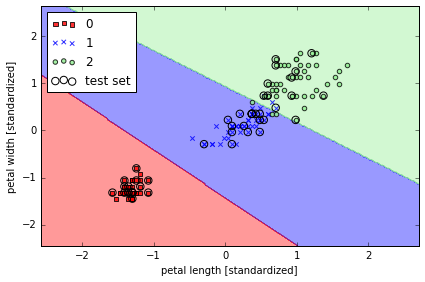

In [19]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=test_idx,
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

## Alternative implementations in scikit-learn

# Solving non-linear problems using a kernel SVM

SVM can be extended for non-linear classification

This is called kernel SVM
* will explain what kernel means
* and introduce kernel tricks :-)

##  Intuition

The following 2D circularly distributed data sets are not linearly separable.

However, we can elevate them to a higher dimensional space for linear separable:
$
\phi(x_1, x_2) = (x_1, x_2, x_1^2 + x_2^2)
$
,
where $\phi$ is the mapping function.

<img src="./images/03_11.png" width=90%> 

## Animation visualization

https://youtu.be/3liCbRZPrZA

https://youtu.be/9NrALgHFwTo

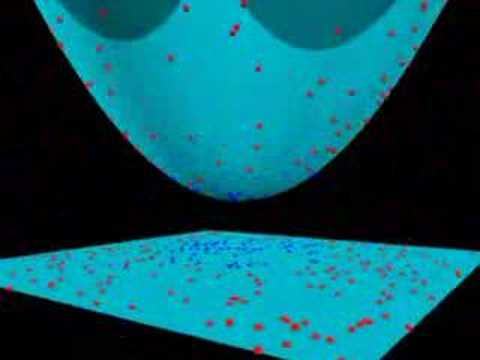

In [20]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA')

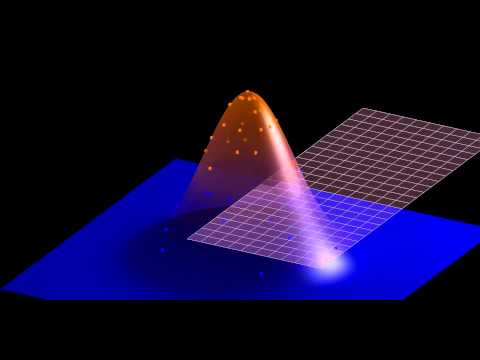

In [21]:
YouTubeVideo('9NrALgHFwTo')

## Using the kernel trick to find separating hyperplanes in higher dimensional space

For datasets that are not linearly separable, we can map them into a higher dimensional space and make them linearly separable.
Let $\phi$ be this mapping:
$\mathbf{z} = \phi(\mathbf{x})$

And we perform the linear decision in the $\mathbf{z}$ instead of the original $\mathbf{x}$ space:
$$y^{(i)} \left( \mathbf{w}^{(i)} \mathbf{z}^{(i)} + w_0\right) \geq 1 - \xi^{(i)}$$

Following similar Lagrangian multiplier optimization as above, we eventually want to optimize:
$$
\begin{align}
L &= \frac{1}{2} \sum_i \sum_j \alpha^{(i)} \alpha^{(j)} y^{(i)} y^{(j)} \left(\mathbf{z}^{(i)}\right)^T \mathbf{z}^{(j)} + \sum_i \alpha^{(i)} \\
&= \frac{1}{2} \sum_i \sum_j \alpha^{(i)} \alpha^{(j)} y^{(i)} y^{(j)} \phi\left(\mathbf{x}^{(i)}\right)^T \phi\left(\mathbf{x}^{(j)}\right) + \sum_i \alpha^{(i)} 
\end{align}
$$

The key idea behind kernel trick, and kernel machines in general, is to represent the high dimensional dot product by a kernel function:
$$K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right) = \phi\left(\mathbf{x}^{(i)}\right)^T \phi\left(\mathbf{x}^{(j)}\right)$$

Intuitively, the data points become more likely to be linearly separable in a higher dimensional space.

## Kernel trick for evaluation

Recall from part of our derivation above:
$$
\frac{\partial L}{\partial \mathbf{w}} = 0 \Rightarrow \mathbf{w} = \sum_i \alpha^{(i)} y^{(i)} \mathbf{z}^{(i)}
$$

Which allows us to compute the discriminant via kernel trick as well:
$$
\begin{align}
\mathbf{w}^T \mathbf{z}
&=
\sum_i \alpha^{(i)} y^{(i)} \left(\mathbf{z}^{(i)}\right)^T \mathbf{z}
\\
&=
\sum_i \alpha^{(i)} y^{(i)} \phi\left(\mathbf{x}^{(i)}\right)^T \phi(\mathbf{x})
\\
&=
\sum_i \alpha^{(i)} y^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}\right)
\end{align}
$$

## Non-linear classification example

<table>
<tr> <td>x <td> y <td>xor(x, y) </tr>
<tr> <td> 0 <td> 0 <td> 0 </tr>
<tr> <td> 0 <td> 1 <td> 1 </tr>
<tr> <td> 1 <td> 0 <td> 1 </tr>
<tr> <td> 1 <td> 1 <td> 0 </tr>
</table>

Xor is not linearly separable
* math proof left as exercise

Random point sets classified via XOR based on the signs of 2D coordinates:

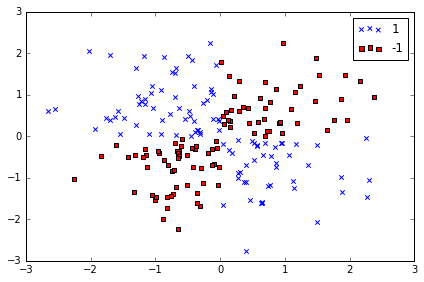

In [22]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

This is the classification result using a rbf (radial basis function) kernel

Notice the non-linear decision boundaries

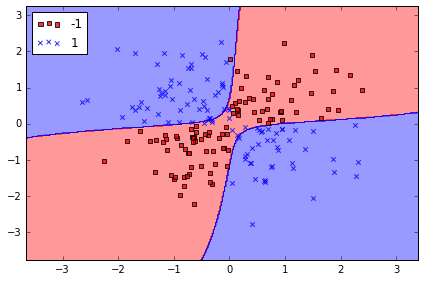

In [23]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

## Types of kernels

A variety of kernel functions can be used.
The only requirement is that the kernel function behaves like inner product;
larger $K(\mathbf{x}, \mathbf{y})$ for more similar $\mathbf{x}$ and $\mathbf{y}$

### Linear
$
K\left(\mathbf{x}, \mathbf{y}\right) = \mathbf{x}^T \mathbf{y}
$

### Polynomials of degree $q$
$
K\left(\mathbf{x}, \mathbf{y}\right) =
(\mathbf{x}^T\mathbf{y} + 1)^q
$

Example for $d=2$ and $q=2$
$$
\begin{align}
K\left(\mathbf{x}, \mathbf{y}\right) &= \left( x_1y_1 + x_2y_2 + 1 \right)^2 \\
&= 1 + 2x_1y_1 + 2x_2y_2 + 2x_1x_2y_1y_2 + x_1^2y_1^2 + x_2^2y_2^2 
\end{align}
$$
, which corresponds to the following kernel function:
$$
\phi(x, y) = \left[1, \sqrt{2}x, \sqrt{2}y, \sqrt{2}xy, x^2, y^2 \right]^T
$$

### Radial basis function (RBF)

Scalar variance:
$$
K\left(\mathbf{x}, \mathbf{y} \right) = e^{-\frac{\left|\mathbf{x} - \mathbf{y}\right|^2}{2s^2}}
$$

General co-variance matrix:
$$
K\left(\mathbf{x}, \mathbf{y} \right) = e^{-\frac{1}{2} \left(\mathbf{x}-\mathbf{y}\right)^T \mathbf{S}^{-1} \left(\mathbf{x} - \mathbf{y}\right)}
$$

General distance function $D\left(\mathbf{x}, \mathbf{y}\right)$:
$$
K\left(\mathbf{x}, \mathbf{y} \right) = e^{-\frac{D\left(\mathbf{x}, \mathbf{y} \right)}{2s^2}}
$$

RBF essentially projects to an infinite dimensional space.

### Sigmoid
$$
K\left(\mathbf{x}, \mathbf{y} \right) = \tanh\left(2\mathbf{x}^T\mathbf{y} + 1\right)
$$

## Kernel SVM for the Iris dataset

Let's apply RBF kernel

The kernel width is controlled by a gamma $\gamma$ parameter for kernel influence
$
K\left(\mathbf{x}, \mathbf{y} \right) =
e^{-\gamma D\left(\mathbf{x}, \mathbf{y} \right)}
$
and $C$ for regularization

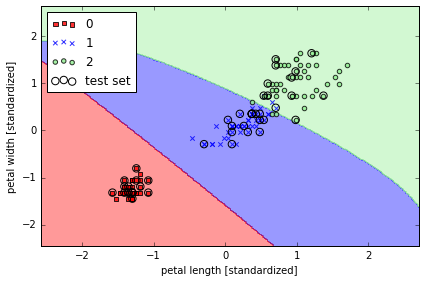

In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=test_idx,
                      xlabel = 'petal length [standardized]', 
                      ylabel = 'petal width [standardized]')

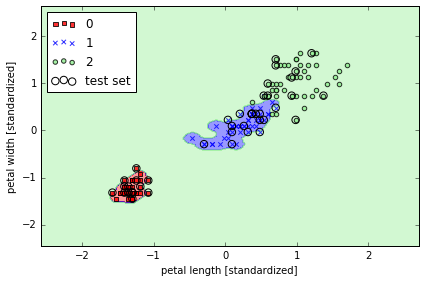

In [25]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=test_idx,
                      xlabel = 'petal length [standardized]', 
                      ylabel='petal width [standardized]')

# Reading
* PML Chapter 3
* IML Chapter 13-1 to 13.7
* [The kernel trick](http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html)

# Decision tree learning

Machine learning can be like black box/magic; the model/method works after tuning parameters and such, but how and why?

Decision tree shows you how it makes decision, e.g. classification.

## Example decision tree

* analogous to flow charts for designing algorithms
* every internal node can be based on some if-statement
* automatically learned from data, not manually programmed by human

<img src="./images/03_15.png" width=80%> 

## Decision tree learning

1. Start with a single node that contains all data
 1. Select a node and split it via some criterion to optimize some objective, usually information/impurity $I$
 2. Repeat until convergence:
  good enough classification measured by $I$;
  complex enough model (overfitting);
2. Each leaf node belongs to one class
 * Multiple leaf nodes can be of the same class
 * Each leaf node can have misclassified samples - majority voting
  
<a href="http://www.cmpe.boun.edu.tr/~ethem/i2ml2e/" title = "Figure 9.1"><img src="./images/fig9p1_iml.svg" width=80%></a>
* usually split along one dimension/feature
* a finite number of choices from the boundaries of sample classes

## Maximizing information gain - getting the most bang for the buck

$I(D)$ information/impurity for a tree node with dataset $D$

Maximize information gain $IG$ for splitting each (parent) node $D_p$ into $m$ child nodes $j$:
$$
IG = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p} I(D_j)
$$
Usually $m=2$ for simplicity (binary split)


Commonly used impurity measures $I$

$p(i|t)$ - probability/proportion of dataset in node $t$ belongs to class $i$

### Entropy

$$
I_H(t) = - \sum_{i=1}^c p(i|t) \log_2 p(i|t)
$$

* $0$ if all samples belong to the same class
* $1$ if uniform distribution
$
0.5 = p(0|t) = p(1|t)
$

<a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)">Entropy (information theory)</a>

Random variable $X$ with probability mass/density function $P(X)$

Information content
$
I(X) = -\log_b\left(P(X)\right)
$

Entropy is the expectation of information
$$
H(X) = E(I(X)) = E(-\log_b(P(X)))
$$

log base $b$ can be $2$, $e$, $10$

Continuous $X$:
$$
H(X) = \int P(x) I(x) \; dx = -\int P(x) \log_b P(x) \;dx
$$
Discrete $X$:
$$
H(X) = \sum_i P(x_i) I(x_i) = -\sum_i P(x_i) \log_b P(x_i)
$$

$-\log_b P(x)$ - number of bits needed to represent $P(x)$
* the rarer the event $\rightarrow$ the less $P(x)$ $\rightarrow$ the more bits

### Gini index

Minimize expected value of misclassification

$$
I_G(t) = \sum_{i=1}^c p(i|t) \left( 1 - p(i|t) \right) = 1 - \sum_{i=1}^c p(i|t)^2
$$

* $p(i|t)$ - probability of class $i$
* $1-p(i|t)$ - probability of misclassification, i.e. $t$ is not class $i$

Similar to entropy
* expected value of information: $-\log_2 p(i|t)$
* information and mis-classification probability: both larger for lower $p(i|t)$

### Classification error

$$
I_e(t) = 1 - \max_i p(i|t)
$$

$
argmax_i \; p(i|t)
$
as the class label for node $t$


## Compare different information measures

Entropy and Gini are probabilisitic
* not assuming the label of the node (decided later after more splitting)

Classification error is deterministic
* assumes the majority class would be the label

Entropy and Gini index are similar, and tend to behave better than classification error
* curves below via a 2-class case
* example in the PML textbook

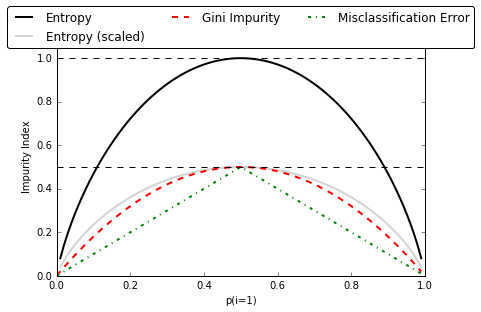

In [26]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

## Building a decision tree

A finite number of choices for split

Split only alone boundaries of different classes

Exactly where? Maxmize margins


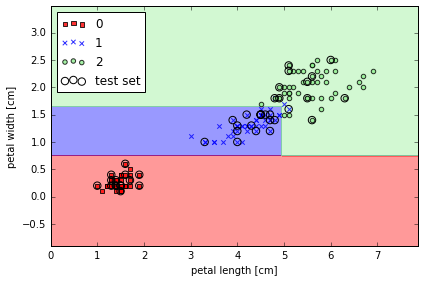

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=test_idx,
                      xlabel='petal length [cm]',ylabel='petal width [cm]')

## Visualize the decision tree

In [28]:
from sklearn.tree import export_graphviz

export_graphviz(tree, 
                out_file='tree.dot', 
                feature_names=['petal length', 'petal width'])

Install [Graphviz](http://www.graphviz.org/)

<!--
<img src="./images/03_18.png" width=80%>
-->

dot -Tsvg tree.dot -o tree.svg

<img src="./images/tree.svg" width=80%>

# Decisions trees and SVM

* SVM considers only margins to nearest samples to the decision boundary
* Decision tree considers all samples

Case studies

## Pruning a decision tree

Split until all leaf nodes are pure?


* not always a good idea due to potential over-fitting

Simplify the tree via pruning

Pre-pruning
* stop splitting a node if the contained data size is below some threshold (e.g. 5% of all data)

Post-pruning
* build a tree first, and remove excessive branches
* reserve a pruning subset separate from the training data
* for each sub-tree (top-down or bottom-up), replace it with a leaf node labeled with the majority vote if not worsen performance for the pruning subset

Pre-pruning is simpler, post-pruning works better

## Combining weak to strong learners via random forests

Forest = collection of trees

An example of ensemble learning (more about this later)
* combine multiple weak learners to build a strong learner
* better generalization, less overfitting

Less interpretable than a single tree

### Random forest algorithm

Decide how many trees to build

To train each tree:
* Draw a random subset of samples (e.g. random sample with replacement of all samples)
* Split each node via a random subset of features (e.g. $d = \sqrt{m}$ of the original dimensionality)

(randomization is a key)

Majority vote from all trees

### Code example

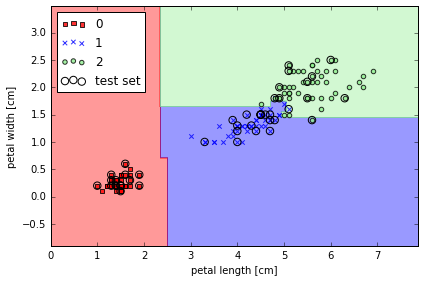

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=test_idx,
                      xlabel = 'petal length [cm]', ylabel = 'petal width [cm]')

# Reading
* PML Chapter 3
* IML Chapter 9

# Parametric versus non-parametric models

* (fixed) number of parameters trained and retained
* amount of data retained
* trade-off between training and evaluation time

## Example

Linear classifiers (SVM, perceptron)
* parameters: $\mathbf{w}$
* data throw away after training
* extreme end of parametric

Kernel SVM
* depends on the type of kernel used (exercise)

Decision tree
* parameters: decision boundaries at all nodes
* number of parameters vary depending on the training data
* data throw away after training
* less parametric than SVM

Personal take:
Parametric versus non-parametric is more of a continuous spectrum than a binary decision.
Many algorithms lie somewhere in between.

# K-nearest neighbors - a lazy learning algorithm

KNN keeps all data and has no trained parameters
* extreme end of non-parametric

How it works:
* Choose the number $k$ of neighbors and a distance measure
* For each sample to classify, find the $k$ nearest neighbors in the dataset
* Assign class label via majority vote

$k$ is a hyper-parameter (picked by human), not a (ordinary) parameter (trained from data by machines)

<img src="./images/03_20.png" width=75%> 

Pro:
* zero training time
* very simple

Con:
* need to keep all data
* evaluation time linearly proportional to data size (acceleration possible though, e.g. kd-tree)
* vulnerable to curse of dimensionality

## Practical usage

[Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) of order $p$:
$
d(\mathbf{x}, \mathbf{y}) = \sqrt[p]{\sum_k |\mathbf{x}_k - \mathbf{y}_k|^p}
$ 
* $p = 2$, Euclidean distance
* $p = 1$, Manhattan distance

<a href="https://en.wikipedia.org/wiki/Minkowski_distance">
<img src="https://upload.wikimedia.org/wikipedia/commons/0/00/2D_unit_balls.svg">
</a>

Number of neighbors $k$ trade-off between bias and variance
* too small $k$ - low bias, high variance

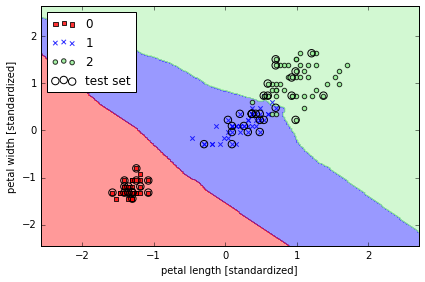

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

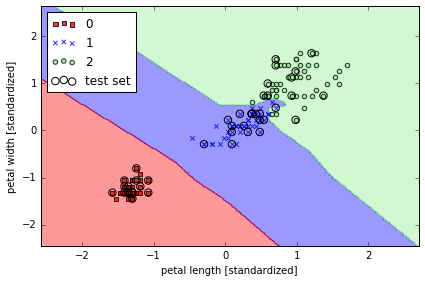

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

Too small k can cause overfitting (high variance).

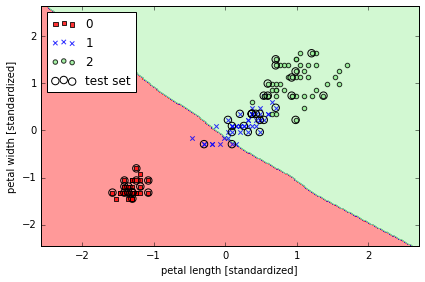

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

Too large k can cause under-fitting (high bias).

How about using different $p$ values for Minkowski distance?

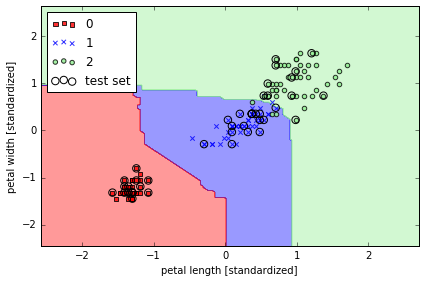

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

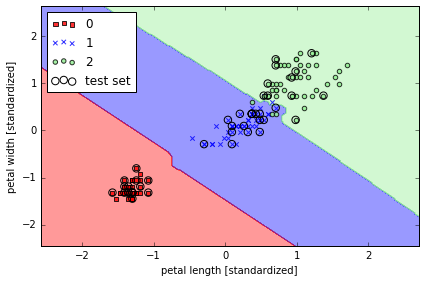

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=10, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=test_idx, 
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

# Reading
* PML Chapter 3